Библиотеки которые можно использовать: librosa, NMFToolbox, Nimfa, Mido/Pretty_midi,MIDIUtil.

Из всех библиотек с реализацией NMF пока остановился на Nimfa, не пойдет с ней - буду пробовать работать с NMFToolbox. Перед тем как запускать код дальше надо установить Nimfa.

In [6]:
pip install nimfa

**Читаем исходный файл**

In [19]:
from scipy.io import wavfile
import numpy as np
import librosa
import nimfa
gamma = 100
f_s, x = wavfile.read("/content/FChopinPreludeOp28n4.wav")
print(f_s)        # sample rate
print(x.dtype)   # int16, int32, etc.
print(x.shape)   # (N,) mono or (N, channels)
print(x[100000])
def init_nmf_template_pitch(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, R))
    for r in range(R):
        W[:, r] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W
def template_pitch(K, pitch, freq_res, tol_pitch=0.05):
    """Defines spectral template for a given pitch

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch (float): Fundamental pitch
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        template (np.ndarray): Nonnegative template vector of size K
    """
    max_freq = K * freq_res
    pitch_freq = 2**((pitch - 69) / 12) * 440
    max_order = int(np.ceil(max_freq / ((1 - tol_pitch) * pitch_freq)))
    #print(max_freq,pitch_freq,max_order)
    template = np.zeros(K)
    for m in range(1, max_order + 1):
        min_idx = max(0, int((1 - tol_pitch) * m * pitch_freq / freq_res))
        max_idx = min(K-1, int((1 + tol_pitch) * m * pitch_freq / freq_res))
        template[min_idx:max_idx+1] = 1 / m
    return template
'''def pitch(p):
  return 2**((p-69)/12) * 440
def interval(freq, cents=20):
  return (freq * 2 ** (-cents/1200), freq * 2 ** (cents/1200))'''
if(x.dtype==np.int32):
  x = x / (2**31)
elif(x.dtype==np.int16):
  x = x / (2**15)
else:
  raise ValueError(f"Unsupported sample type: {x.dtype}")
spectrogram = np.abs(librosa.stft(x, n_fft=2048,hop_length=1024))
spectrogram_compressed = np.log(1+gamma*spectrogram)
print(x[100000])
print(np.min(spectrogram_compressed),np.max(spectrogram_compressed))
print(spectrogram_compressed.shape)
pitches = [x+21 for x in range(88)]
freq_res = f_s/(2 * 1025)
print(freq_res)
W_temp = init_nmf_template_pitch(1025,pitches,freq_res)
H_temp = np.random.rand(88, spectrogram_compressed.shape[1])
#nmf = nimfa.Nmf(spectrogram_compressed, seed='fixed', W=W_temp)
nmf = nimfa.Nmf(
    spectrogram_compressed,
    rank=88,
    seed='fixed',
    W=W_temp,
    H=H_temp,
    max_iter=200
)
nmf_fit = nmf()
W_est = nmf_fit.basis()
H_est = nmf_fit.coef()

/tmp/ipython-input-3180636591.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  f_s, x = wavfile.read("/content/FChopinPreludeOp28n4.wav")


44100
int16
(5556600,)
-3447
-0.105194091796875
5.323435231344913e-06 10.672143537149704
(1025, 5427)
21.51219512195122


In [ ]:
m = template_pitch(K=1025,pitch=69,freq_res=1)
print(type(m))
print(np.max(m))

NameError: name 'template_pitch' is not defined

In [ ]:
pitches = [x+21 for x in range(88)]
print(pitches)

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]


In [7]:
!grep -rl "np.mat" /usr/local/lib/python3.12/dist-packages/nimfa | xargs sed -i 's/np.mat/np.asmatrix/g'

sed: no input files


In [3]:
!grep -rl "asmatrixrix" /usr/local/lib/python3.12/dist-packages/nimfa | xargs sed -i 's/asmatrixrix/asmatrix/g'


In [4]:
!grep -R "asmatrixrix" /usr/local/lib/python3.12/dist-packages/nimfa

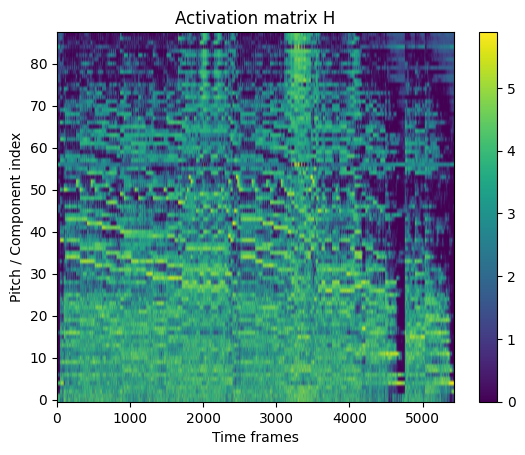

In [39]:
#print(W_est.shape)
#print(H_est[:,100])
import matplotlib.pyplot as plt
#H_est_visualisation = np.log(1+10*H_est)
from scipy.signal import butter, filtfilt

b, a = butter(2, 0.1)   # low-pass along time
#H_est_visualisation = filtfilt(b, a, H_est, axis=1)
H_est_visualisation = np.log(1+100*H_est)
#H_est_visualisation = filtfilt(b, a, H_est_visualisation, axis=1)
plt.figure()
plt.imshow(H_est_visualisation, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()